In [1]:
# Importing the toolbox (takes several seconds)
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import deeplabcut
import math

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
video_dir = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos'
movname = 'NINJAV_S001_S001_T034_008_c'
video='%s.mp4' % movname
# DLCscorer='DeepCut_resnet50_openfieldOct30shuffle1_15001'
DLCscorer = 'DLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_el'

dataname = str(Path(video).stem) + DLCscorer + '.h5'
#loading output of DLC
results_fpath = os.path.join(video_dir, dataname)
df0 = pd.read_hdf(results_fpath)

In [3]:
scorer = df0.columns.get_level_values(0)[0]
scorer

'DLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000'

In [4]:
from deeplabcut.utils import auxiliaryfunctions
from deeplabcut.utils.video_processor import (
    VideoProcessorCV as vp,)  # used to CreateVideo

from matplotlib.collections import LineCollection


In [5]:
def get_segment_indices(bodyparts2connect, all_bpts):
    bpts2connect = []
    for bpt1, bpt2 in bodyparts2connect:
        if bpt1 in all_bpts and bpt2 in all_bpts:
            bpts2connect.extend(
                zip(
                    *(
                        np.flatnonzero(all_bpts == bpt1),
                        np.flatnonzero(all_bpts == bpt2),
                    )
                )
            )
    return bpts2connect

In [6]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# segs[b1_ix1] - line segment belonging to animal 1
# segs[b1_ix][0] - first point defining line segment^

def get_centroid(segs, animal='band1'):

    b1_ix1 = 0 if animal=='band1' else 1
    b1_ix2 = 2 if animal=='band1' else 3
    vec_ix = 0

    A=segs[b1_ix1][0,:]
    B=segs[b1_ix1][1,:]

    C=segs[b1_ix2][0,:]
    D=segs[b1_ix2][1,:]
    cx, cy = line_intersection((A, B), (C, D))

    return cx, cy

In [7]:
def align_vectors(a, b):
    b = b / np.linalg.norm(b) # normalize a
    a = a / np.linalg.norm(a) # normalize b
    v = np.cross(a, b)
    # s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R

def calculate_2d_rotmat(u, v):
    v1 = u / np.linalg.norm(u)
    #v2 = (0, 1)
    #theta = np.arccos( np.dot(v1, v) )
    #deg = np.rad2deg(theta)
    #print(theta, deg)
    theta = math.atan2(u[1], u[0]) - math.atan2(v[1], v[0])

    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return rot, theta

#def get_transformed_coords(centered_ap)
def get_2d_rotmat(ix, df_ctr, v=(0, 1)):
    x1, y1 = df_ctr['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
    x2, y2 = df_ctr['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]

    #u = (x1-x2), (y1 - y2)
    u = (x2-x1), (y2 - y1)
    # Rotate
    # v = (0, 1)
    R, theta = calculate_2d_rotmat(u, v)
    return R, theta

In [8]:
config_path = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/config.yaml'
cfg = auxiliaryfunctions.read_config(config_path)

## start with 1 animal

In [102]:
bodyparts2connect = cfg['skeleton']
animalid = 'band1'
df = df0.loc[:, (slice(None), [animal])].copy()
bodyparts = df.columns.get_level_values("bodyparts")[::3]
bodyparts

Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')

In [103]:
bodyparts2connect = [['mantleA', 'mantleR1'], ['mantleR1', 'mantleR2'],\
                     ['mantleR2', 'mantleR3'], ['mantleR3', 'mantleP'],\
                     ['mantleP', 'mantleL3'], ['mantleL3', 'mantleL2'],\
                     ['mantleL2', 'mantleL1'], ['mantleL1', 'mantleA']]
all_bpts = df.columns.get_level_values("bodyparts")[::3][0:11]
print(all_bpts)
#all_bpts = df.columns.get_level_values("bodyparts")[::3]
inds = get_segment_indices(bodyparts2connect, all_bpts)
print(inds) # these are used to index into coords
bodyparts = df.columns.get_level_values("bodyparts")[::3]

Index(['eyeLeft', 'eyeRight', 'armbase', 'mantleA', 'mantleP', 'mantleL1',
       'mantleL2', 'mantleL3', 'mantleR1', 'mantleR2', 'mantleR3'],
      dtype='object', name='bodyparts')
[(3, 8), (8, 9), (9, 10), (10, 4), (4, 7), (7, 6), (6, 5), (5, 3)]


In [104]:
nx = int(np.nanmax(df.xs("x", axis=1, level="coords")))
ny = int(np.nanmax(df.xs("y", axis=1, level="coords")))
dpi=200

# center

In [105]:
n_bodyparts = len(np.unique(df.columns.get_level_values("bodyparts")[::3]))
print(n_bodyparts)
all_bpts = df.columns.get_level_values("bodyparts")[::3][0:n_bodyparts]
#all_bpts = df.columns.get_level_values("bodyparts")[::3]
inds = get_segment_indices(bodyparts2connect, all_bpts)

11


In [106]:
# calculate center for AP/ML mantle axis
a = df[scorer]['band1']['mantleA'][['x', 'y']].values
p = df[scorer]['band1']['mantleP'][['x', 'y']].values

lt = df[scorer]['band1']['mantleL2'][['x', 'y']].values
rt = df[scorer]['band1']['mantleR2'][['x', 'y']].values

ctrs = np.array([line_intersection( (a_, p_), (lt_, rt_) ) \
                 for a_, p_, lt_, rt_ in zip(a, p, lt, rt)])

In [107]:
all_bpts = df.columns.get_level_values("bodyparts")[::3][0:11]

ctr_dict = dict((k, {}) for k in all_bpts)
for bp in all_bpts:
    xv = df[scorer][animal][bp]['x'] - ctrs[:, 0]
    yv = df[scorer][animal][bp]['y'] - ctrs[:, 1]
    ctr_dict[bp]['x'] = xv
    ctr_dict[bp]['y'] = yv
# turn into dataframe
reform = {(outerKey, innerKey): values for outerKey, innerDict in ctr_dict.items() \
          for innerKey, values in innerDict.items()}
df_ctr = pd.DataFrame(reform)

In [108]:
u_a = df_ctr['mantleA'][['x', 'y']].values
u_p = df_ctr['mantleP'][['x', 'y']].values
centered_ap = np.array([u_a, u_p]).swapaxes(0, 1)

In [109]:
keypoint_size=5
n_frames_plot = centered_ap[::20].shape[0]
t_cmap = plt.cm.jet(np.linspace(0,1,n_frames_plot))

In [110]:
#df_single = df[scorer]['band1'].copy()
n_frames = df.shape[0]
xyp = df.values.reshape((n_frames, -1, 3))
print(n_frames, xyp.shape)

# get coords
n_frames = df_ctr.shape[0]
print(df_ctr.shape, df.shape)
xyp_ctr = df_ctr.values.reshape((n_frames, -1, 2)) #.shape
print(xyp_ctr.shape, xyp.shape, df_ctr.shape)

8991 (8991, 11, 3)
(8991, 22) (8991, 33)
(8991, 11, 2) (8991, 11, 3) (8991, 22)


In [111]:
# Rotate
ix = 0
v=(0, 1)
R, theta = get_2d_rotmat(ix, df_ctr, v=v)
coords_ctr = xyp_ctr[ix, :, :] # grab first coords
coords_rot = coords_ctr.dot(R)
coords = xyp[ix, :, :]

# get line
line_coord = centered_ap[ix]
line_coord = np.expand_dims(line_coord, 0)
ap_coord = [centered_ap[ix][0][0], centered_ap[ix][0][1]]

In [112]:
%matplotlib notebook

<IPython.core.display.Javascript object>


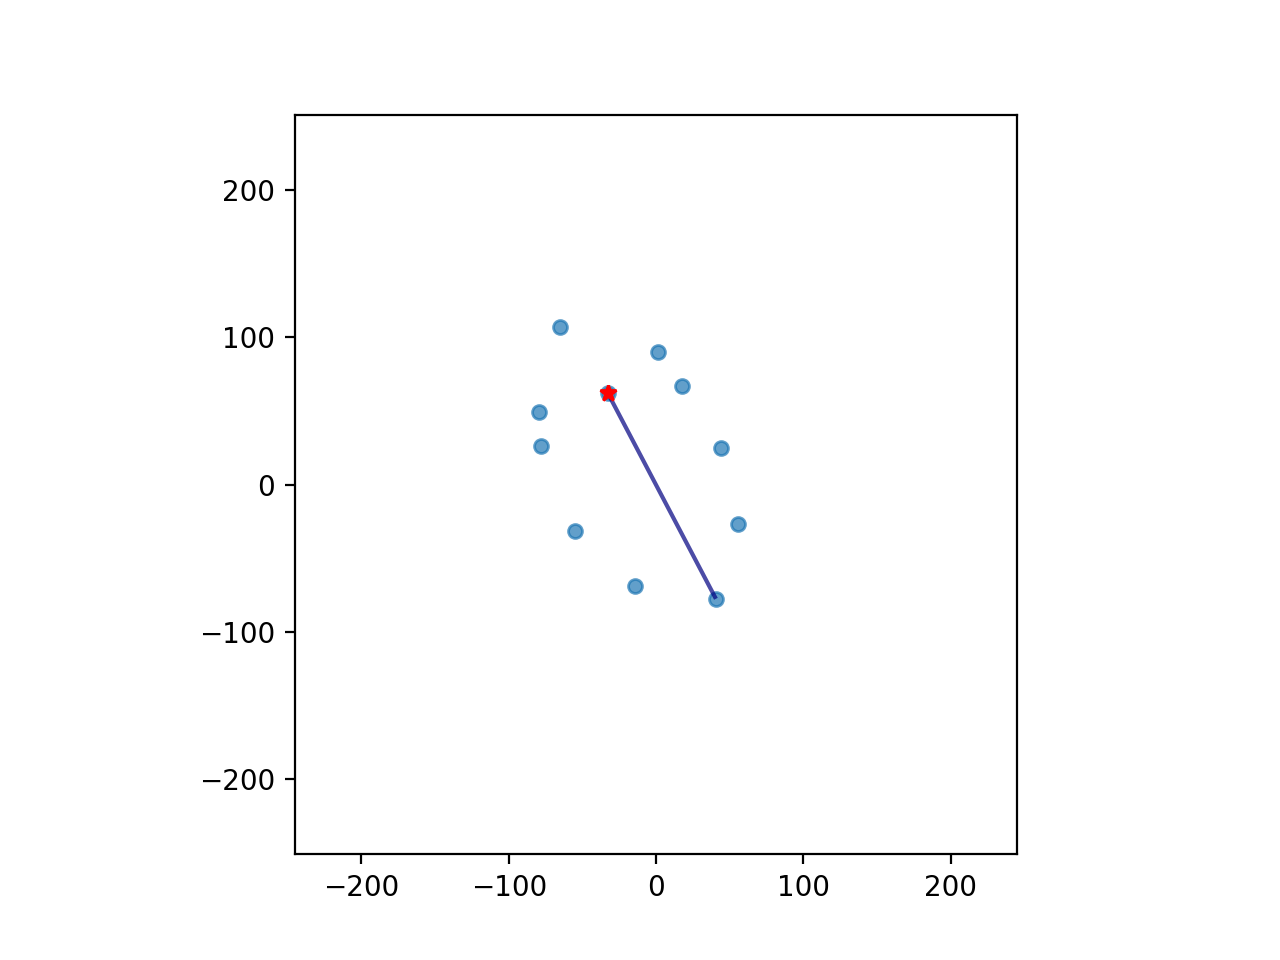

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
scat = ax.scatter([], [], s=keypoint_size ** 2, alpha=0.7)
coll = LineCollection( line_coord, colors=t_cmap, alpha=0.7)
scat.set_offsets(coords_ctr) #[0:11])
ax.set_xlim(-nx/8, nx/8)
ax.set_ylim(-ny/8, ny/8)
ax.add_collection(coll)
ax.set_aspect('equal')
ax.plot(ap_coord[0], ap_coord[1], 'r*')

<IPython.core.display.Javascript object>


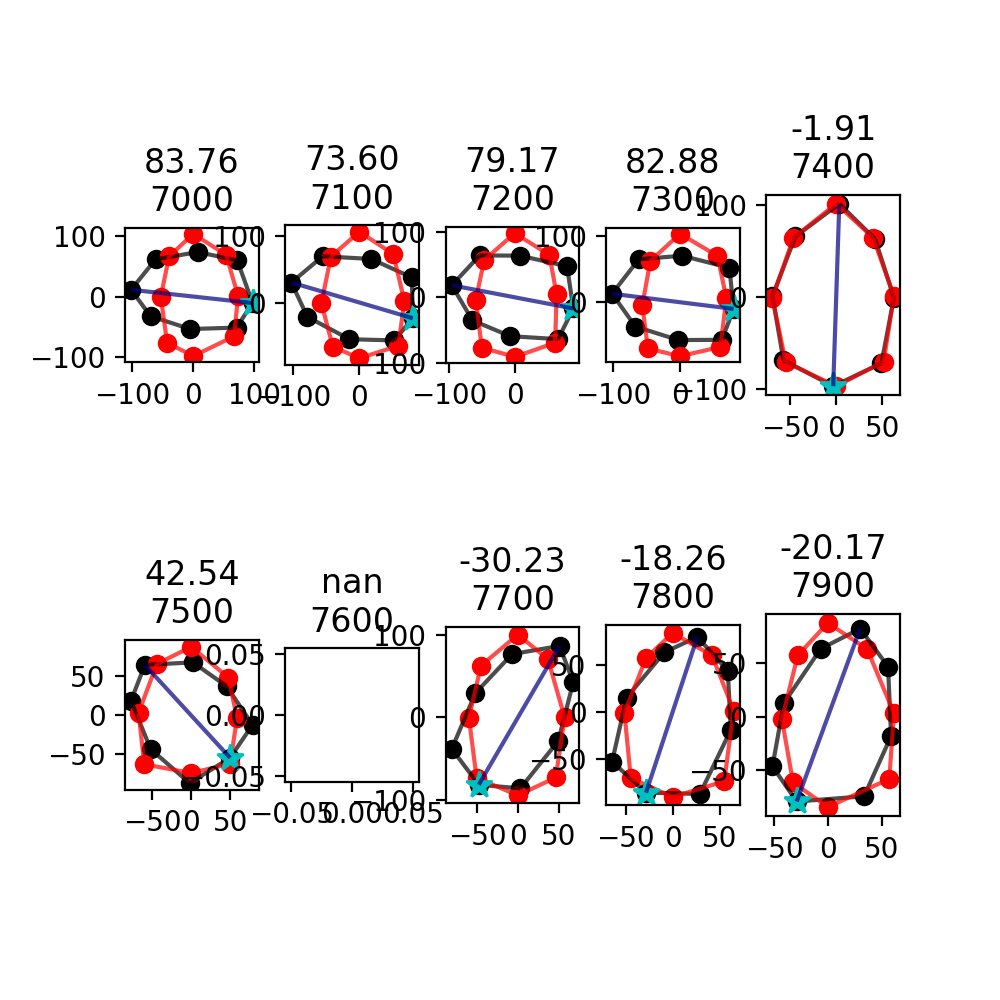

In [114]:
# ---
#fig, ax  = plt.subplots(figsize=(5,5))
start_ix = 7000
stop_ix = 8000
incr = 100
n_subplots = len(np.arange(start_ix, stop_ix, incr))

fig, axes = plt.subplots(2, int(np.floor(n_subplots/2)), figsize=(1*n_subplots/2, 1*n_subplots/2))

for i, ix in enumerate(np.arange(start_ix, stop_ix, incr)):
    ax = axes.flat[i]
    # get rot
    R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    coords_rot = coords_ctr.dot(R)
    # get line
    line_coord = centered_ap[ix]
    line_coord = np.expand_dims(line_coord, 0)
    ap_coord = [centered_ap[ix][0][0], centered_ap[ix][0][1]]

    # not rotated
    ax.scatter(coords_ctr[np.unique(inds), 0], coords_ctr[np.unique(inds), 1], c='k')
    segs = coords_ctr[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) #if inds else []
    coll = LineCollection(segs, colors='k', alpha=0.7)
    ax.add_collection(coll)
    # Rotate
    ax.scatter(coords_rot[np.unique(inds), 0], coords_rot[np.unique(inds), 1], c='r')
    segs_rot = coords_rot[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) #if inds else []
    col2 = LineCollection(segs_rot, colors='r', alpha=0.7)
    ax.add_collection(col2)

    ax.plot(ap_coord[0], ap_coord[1], 'c*', markersize=10)
    col0 = LineCollection( line_coord, colors=t_cmap, alpha=0.7)
    ax.add_collection(col0)
    
    ax.set_aspect('equal')
    
    ax.set_title('%.2f\n%i' % (np.rad2deg(theta), ix), fontsize=12)
    
# plt.subplots_adjust(hspace=0.1)

<IPython.core.display.Javascript object>


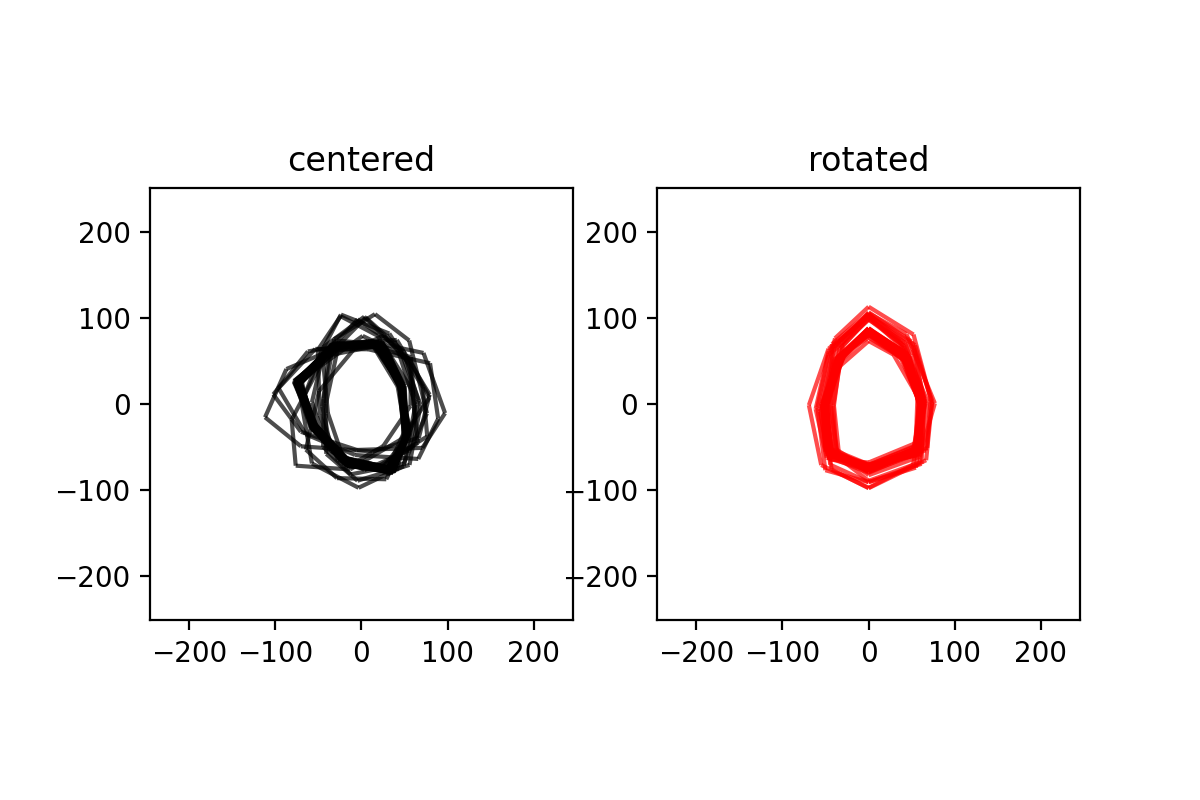

In [115]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(6,4))
ax1.set_title('centered')
ax2.set_title('rotated')
for ix in np.arange(0, 9000, 200):
    R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    coords_rot = coords_ctr.dot(R)

    # not rotated
    #ax1.scatter(coords_ctr[np.unique(inds), 0], coords_ctr[np.unique(inds), 1], c='k')
    segs = coords_ctr[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    coll = LineCollection(segs, colors='k', alpha=0.7)
    ax1.add_collection(coll)
    # Rotate
    #ax2.scatter(coords_rot[np.unique(inds), 0], coords_rot[np.unique(inds), 1], c='r')
    segs = coords_rot[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    col2 = LineCollection(segs, colors='r', alpha=0.7)
    ax2.add_collection(col2)

for ax in fig.axes:
    ax.set_aspect('equal')
    ax.set_xlim(-nx/8, nx/8)
    ax.set_ylim(-ny/8, ny/8)

# Apply to image

In [116]:
from PIL import Image, ImageDraw

In [117]:
# !pip install pickle5

In [118]:
# !pip install pickle5
import pickle5 as pkl

In [119]:
from shapely.geometry import Polygon, MultiPoint
import cv2

In [120]:
%matplotlib notebook

### load metadata

In [121]:
meta_fpath = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_cDLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_meta.pickle'
video_fpath  = results_fpath.replace('%s_el.h5' % scorer, '.mp4')
print(video_fpath)

/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_c.mp4


In [122]:
displaycropped=True
with open(meta_fpath, 'rb') as f:
    metadata = pkl.load(f)
# metadata = auxiliaryfunctions.load_video_metadata(
#     video_dir, vname, scorer)
cropping = metadata["data"]["cropping"]
cropping
[x1, x2, y1, y2] = metadata["data"]["cropping_parameters"]
print(x1, x2, y1, y2)
if displaycropped:
    ny, nx= y2-y1,x2-x1
else:
    ny, nx= clip.height(), clip.width()

927 3178 3 2153


In [123]:
# print(video_fpath)
# clip = vp(fname=video_fpath, fps=30)

### body part vertices into polygon

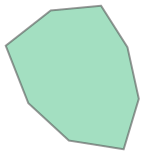

In [124]:
plot_ixs = [list(bodyparts).index(i) for i in np.unique(bodyparts2connect)]

xv = coords[plot_ixs, 0]
yv = coords[plot_ixs, 1]
#polygon = np.array([[int(i[0]), int(i[1])] for i in coords[np.unique(inds)]])
polygon = list(zip(xv, yv))
polyshape = MultiPoint(polygon).convex_hull
#p = Polygon(list(zip(xv, yv)))
polyshape

## convert poly coords into ints

In [125]:
# Extract the point values that define the perimeter of the polygon
px, py = polyshape.exterior.coords.xy
int_px = [int(i) for i in px]
int_py = [int(i) for i in py]
#poly = list(zip(px, py))
poly = list(zip(int_px, int_py))

## load image and draw mask 

In [126]:
clip = vp(fname=video_fpath, fps=30)
im = clip.load_frame()
im = im[y1:y2, x1:x2]

img = Image.fromarray(np.uint8(im)) #*255)
ImageDraw.Draw(img).polygon(poly, outline=1, fill=0)
mask = np.array(img)

<IPython.core.display.Javascript object>


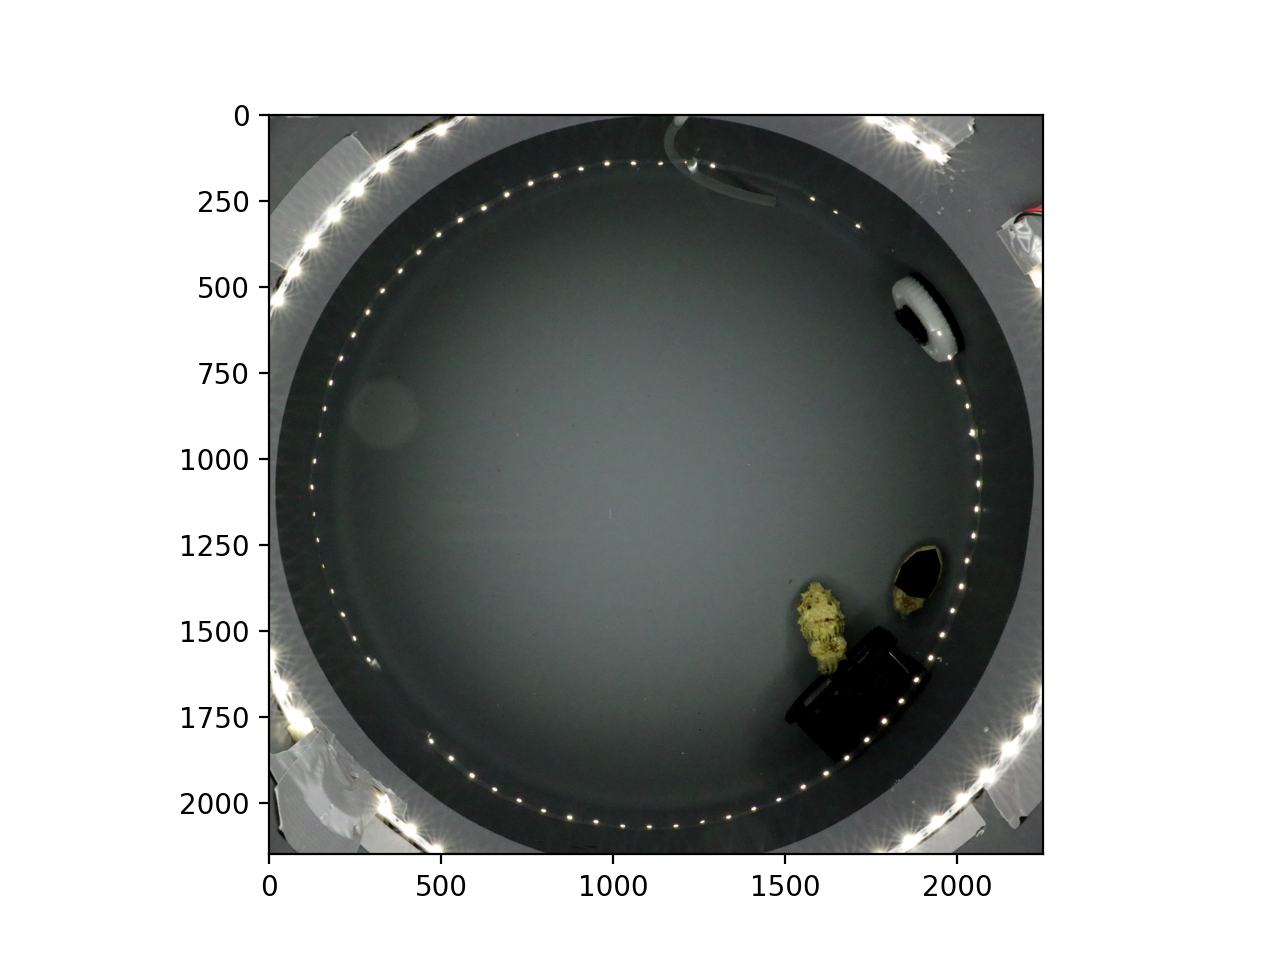

In [127]:
plt.figure
plt.imshow(mask)

## rotate the image itself

In [128]:
# Grab specififed frame
ix = 0
tx, ty = ctrs[ix, :] # offset to center

cap = cv2.VideoCapture(video_fpath)
total_frames = cap.get(7)
cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [129]:
rows, cols, _ = np.array(im).shape
tx, ty = ctrs[ix, :]
M = np.float32([[1,0, -tx],[0,1, -ty]])
#dst = cv2.warpAffine(im,M,(cols,rows))

R, theta = get_2d_rotmat(ix, df_ctr, v=v)
print(np.rad2deg(theta))
# M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), np.rad2deg(theta),1)
rot_pivot = (tx, ty) #( (cols-1)/2.0, (rows-1)/2.0 )
M = cv2.getRotationMatrix2D(rot_pivot, np.rad2deg(theta),1)
dst2 = cv2.warpAffine(im, M, (cols,rows))

-152.27768805488125


In [135]:
coords = xyp[ix, :, :]
print(coords.shape)

(11, 3)


In [136]:
coords_trans = coords.dot(M.T) #coords[:, 0:2].dot(M)

<IPython.core.display.Javascript object>


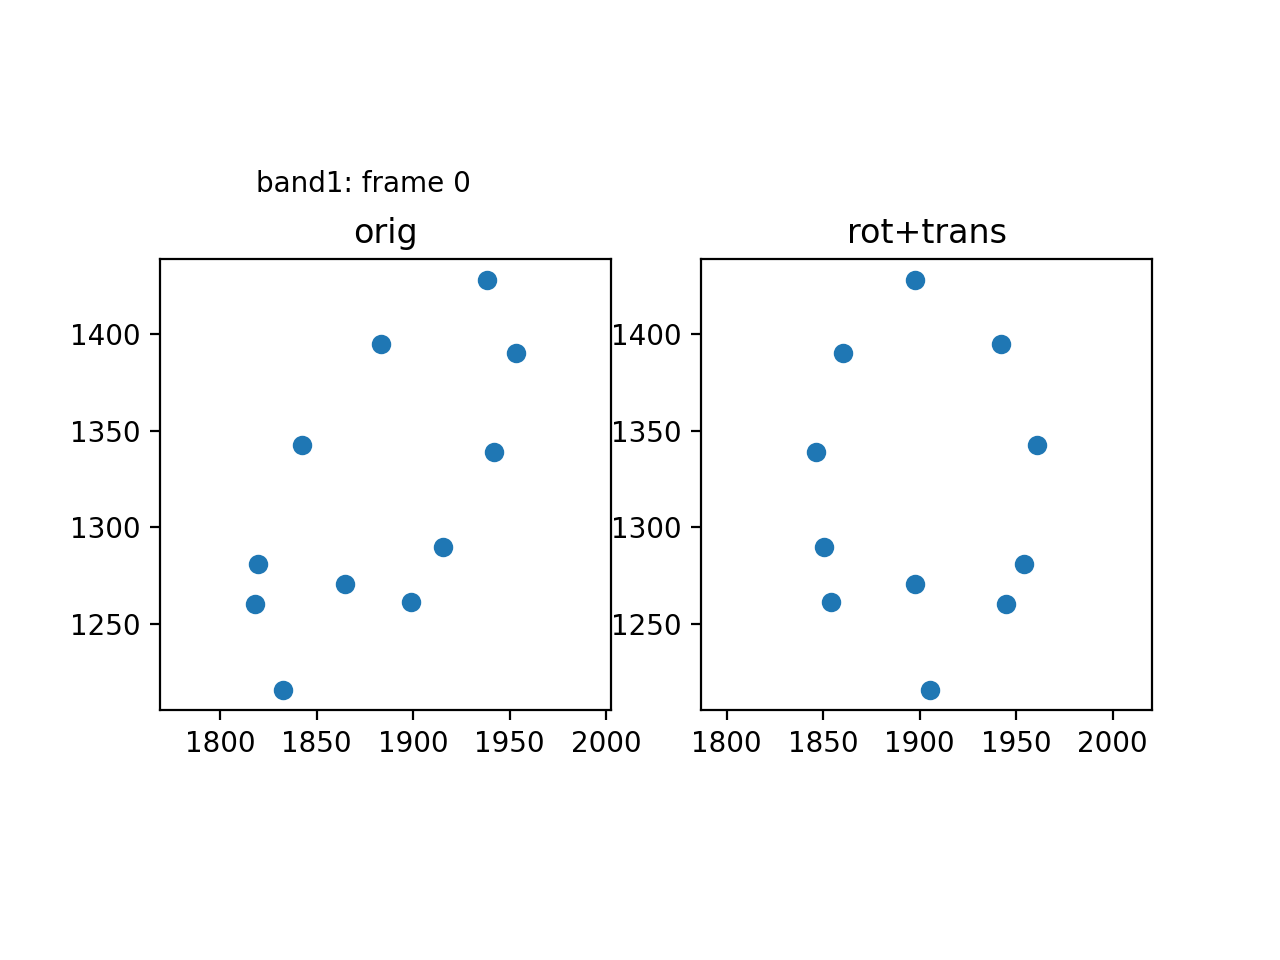

Text(0.2, 0.8, 'band1: frame 0')

In [137]:
fig, axes = plt.subplots(1, 2)
ax=axes[0]
ax.scatter(coords[:, 0], coords_trans[:, 1])
ax.set_title('orig')
ax=axes[1]
ax.scatter(coords_trans[:, 0], coords_trans[:, 1])
ax.set_title('rot+trans')
for ax in axes:
    ax.set_aspect('equal')
    ax.set_box_aspect(1)
fig.text(0.2, 0.8, "%s: frame %i" % (animalid, ix))

<IPython.core.display.Javascript object>


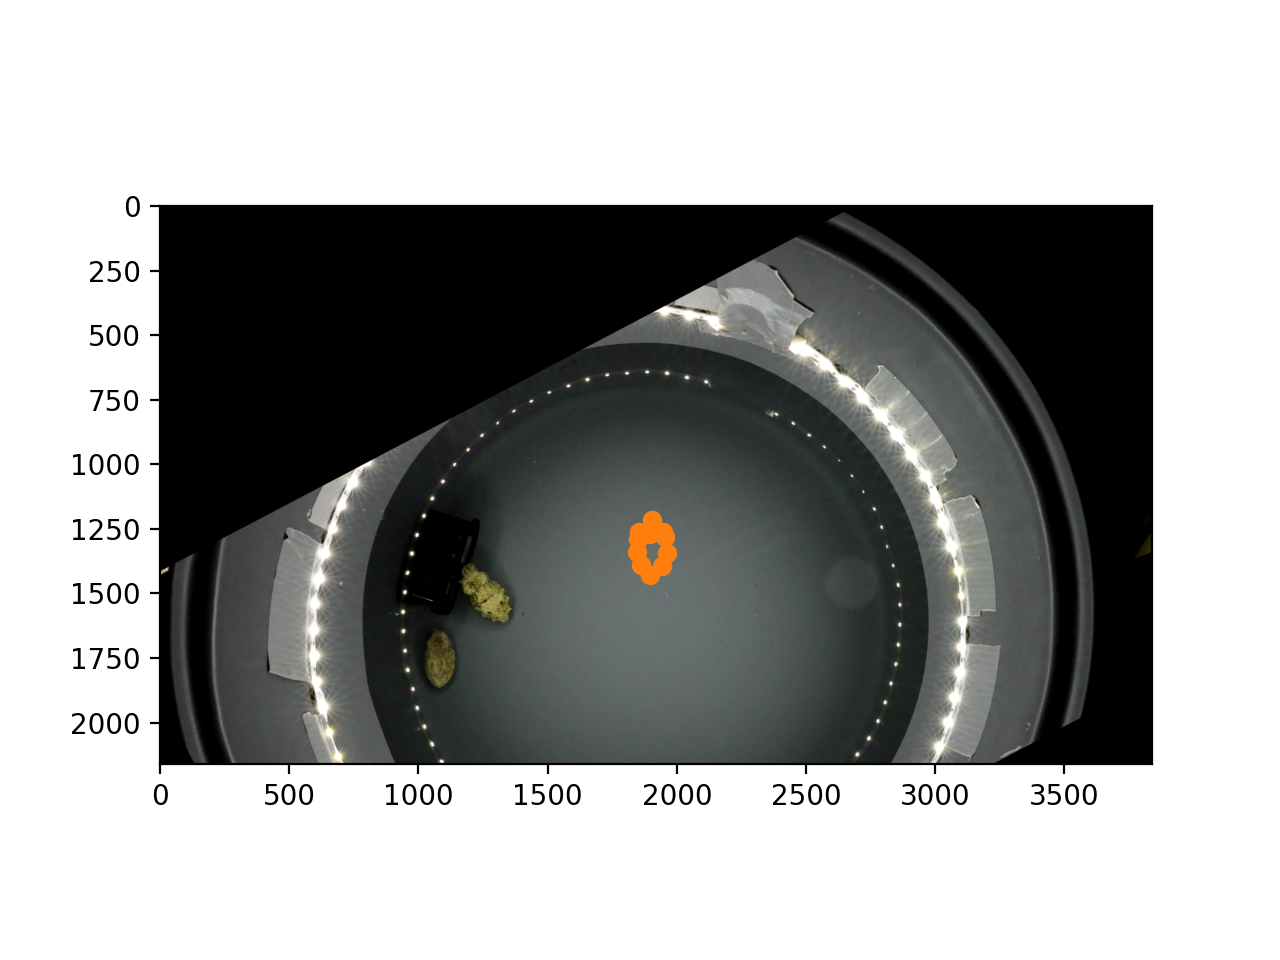

In [138]:
fig, ax = plt.subplots()
ax.imshow(dst2) #[0:1200, 0:1200] )
#ax.set_aspect('equal')

ax.scatter(coords_trans[:, 0], coords_trans[:, 1])
ax.scatter(coords_trans[:, 0], coords_trans[:, 1])

In [109]:
from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter
from tqdm import trange


In [475]:
import cv2

def align_vectors(a, b):
    b = b / np.linalg.norm(b) # normalize a
    a = a / np.linalg.norm(a) # normalize b
    v = np.cross(a, b)
    # s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R

def calculate_2d_rotmat(u, v):
    v1 = u / np.linalg.norm(u)
    #v2 = (0, 1)
    #theta = np.arccos( np.dot(v1, v) )
    #deg = np.rad2deg(theta)
    #print(theta, deg)
    theta = math.atan2(u[1], u[0]) - math.atan2(v[1], v[0])

    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return rot, theta

#def get_transformed_coords(centered_ap)
def get_2d_rotmat(ix, df_ctr, v=(0, 1)):
    x1, y1 = df_ctr['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
    x2, y2 = df_ctr['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]

    #u = (x1-x2), (y1 - y2)
    u = (x2-x1), (y2 - y1)
    # Rotate
    # v = (0, 1)
    R, theta = calculate_2d_rotmat(u, v)
    return R, theta

#def get_transformed_coords(centered_ap)
def get_2d_rotmat_multiindex(ix, df_ctr, animal, scorer=False, v=(0, 1)):
    if scorer:
        x1, y1 = df_ctr[animal]['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
        x2, y2 = df_ctr[animal]['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]
    else:
        x1, y1 = df_ctr[animal]['mantleA'][['x', 'y']].values[ix] #centered_ap[ix][0] #[  97.15844559,  -10.61721119]
        x2, y2 = df_ctr[animal]['mantleP'][['x', 'y']].values[ix] #centered_ap[ix][1] #[-102.24255441,   11.17278881]

    #u = (x1-x2), (y1 - y2)
    u = (x2-x1), (y2 - y1)
    # Rotate
    # v = (0, 1)
    R, theta = calculate_2d_rotmat(u, v)
    return R, theta

In [466]:
df = df0.copy()
fov_x = int(np.nanmax(df.xs("x", axis=1, level="coords")))
fov_y = int(np.nanmax(df.xs("y", axis=1, level="coords")))
dpi=200
print(fov_x, fov_y)


2064 2007


In [467]:
n_frames = df.shape[0]
xyp = df.values.reshape((n_frames, -1, 3))

In [468]:
# calculate center for AP/ML mantle axis
a = df[scorer]['band1']['mantleA'][['x', 'y']].values
p = df[scorer]['band1']['mantleP'][['x', 'y']].values

lt = df[scorer]['band1']['mantleL2'][['x', 'y']].values
rt = df[scorer]['band1']['mantleR2'][['x', 'y']].values

ctrs = np.array([line_intersection( (a_, p_), (lt_, rt_) ) \
                 for a_, p_, lt_, rt_ in zip(a, p, lt, rt)])

In [469]:
animals=['band1', 'band2']

In [479]:
d_=[]
for animal in animals:
    ctr_dict = dict((k, {}) for k in all_bpts)
    for bp in all_bpts:
        xv = df[scorer][animal][bp]['x'] - ctrs[:, 0]
        yv = df[scorer][animal][bp]['y'] - ctrs[:, 1]
        ctr_dict[bp]['x'] = xv
        ctr_dict[bp]['y'] = yv
        ctr_dict[bp]['likelihood'] = df[scorer][animal][bp]['likelihood']
    # turn into dataframe
    reform = {(outerKey, innerKey): values for outerKey, innerDict in ctr_dict.items() \
              for innerKey, values in innerDict.items()}
    tmpdf = pd.DataFrame(reform)
    d_.append(tmpdf)
df_ctr = pd.concat({animals[0]: d_[0], animals[1]: d_[1]},axis=1)
df_ctr.columns = df_ctr.columns.rename('individuals', level=0)
df_ctr.columns = df_ctr.columns.rename('bodyparts', level=1)
df_ctr.columns = df_ctr.columns.rename('coords', level=2)
df_ctr.shape, df.shape


((8991, 66), (8991, 66))

In [480]:
n_frames_ctr = df_ctr.shape[0]
xyp_ctr = df_ctr.values.reshape((n_frames_ctr, -1, 3)) #.shape

In [482]:
target_animal='band1'
v=(0, 1)
df_=[]
#for animal in animals:
d_=[]
for ix in df_ctr.index.tolist():
    R, theta = get_2d_rotmat_multiindex(ix, df_ctr, target_animal, scorer=False, v=(0, 1))
    #R, theta = get_2d_rotmat(ix, df_ctr, v=v)
    coords_ctr = xyp_ctr[ix, :, :] # grab first coords
    subcoords = np.array([coords_ctr[:, 0], coords_ctr[:, 1]]).T
    coords_rot = subcoords.dot(R)
    new_coords = np.array([coords_rot[:, 0], coords_rot[:, 1], coords_ctr[:, 2]]).T

    d1 = dict((k, {'x': x, 'y': y, 'likelihood': L}) \
              for k, (x, y, L) in zip(all_bpts, new_coords[0:n_bodyparts]))
    d2 = dict((k, {'x': x, 'y': y, 'likelihood': L}) \
              for k, (x, y, L) in zip(all_bpts, new_coords[n_bodyparts:]))
    
    reform1 = {(outerKey, innerKey): values for outerKey, innerDict in d1.items() \
              for innerKey, values in innerDict.items()}
    tmpdf1 = pd.DataFrame(reform1, index=[ix])
    reform2 = {(outerKey, innerKey): values for outerKey, innerDict in d2.items() \
              for innerKey, values in innerDict.items()}
    tmpdf2 = pd.DataFrame(reform2, index=[ix])
    
    curr_row_list = [tmpdf1, tmpdf2]
    curr_row = pd.concat({animals[0]: curr_row_list[0], animals[1]: curr_row_list[1]},axis=1)
    d_.append(curr_row)
tmpdf0 = pd.concat(d_, axis=0)
#tmpdf2.columns = tmpdf2.columns.rename(animal, level=0)
#df_.append(tmpdf0)
df_rot = tmpdf0.copy() #pd.concat({animals[0]: df_[0], animals[1]: df_[1]},axis=1)
df_rot.columns = df_rot.columns.rename('individuals', level=0)
df_rot.columns = df_rot.columns.rename('bodyparts', level=1)
df_rot.columns = df_rot.columns.rename('coords', level=2)
df_rot.shape, df_ctr.shape

((8991, 66), (8991, 66))

In [484]:
n_frames = df_ctr.shape[0]
xyp = tmpdf0.values.reshape((n_frames, -1, 3))
np.nanmin(xyp), np.nanmax(xyp)


(-1167.4294569203862, 1733.5698353654664)

In [521]:
xyp = df.values.reshape((n_frames, -1, 3))
xyp_ctr = df_ctr.values.reshape((n_frames, -1, 3))

In [890]:
ix = 6000

cap = cv2.VideoCapture(video_fpath)
total_frames = cap.get(7)

[x1, x2, y1, y2] = metadata["data"]["cropping_parameters"]

cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im[y1:y2, x1:x2]

# clip = vp(fname=video_fpath, fps=30)
# im = clip.load_frame()
# im = im[y1:y2, x1:x2]
# img = Image.fromarray(np.uint8(im)) #*255)
# ImageDraw.Draw(img).polygon(poly, outline=1, fill=0)
# mask = np.array(img)

In [891]:
coords = xyp[ix, :, :]

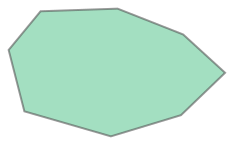

In [893]:
plot_ixs = [list(bodyparts).index(i) for i in np.unique(bodyparts2connect)]
plot_ixs = np.array(plot_ixs) + n_bodyparts
np.unique(bodyparts2connect)
xv = coords[plot_ixs, 0]
yv = coords[plot_ixs, 1]
#polygon = np.array([[int(i[0]), int(i[1])] for i in coords[np.unique(inds)]])
polygon = list(zip(xv, yv))
polyshape = MultiPoint(polygon).convex_hull
#p = Polygon(list(zip(xv, yv)))
polyshape

In [894]:
# pts = poly.copy()
# pts[:, 0] -= ctrs[ix, 0]
# pts[:, 1] -= ctrs[ix, 1]

# Extract the point values that define the perimeter of the polygon
px, py = polyshape.exterior.coords.xy
poly_ft = list(zip(px, py))
poly = np.array(poly_ft) #.dot(R)

int_px = [int(round(i)) for i in poly[:, 0]]
int_py = [int(round(i)) for i in poly[:, 1]]
#poly = list(zip(px, py))
poly_int = list(zip(int_px, int_py)) ##DIAG

# poly_ft = list(zip(px, py))
# poly = list(zip(int_px, int_py))
pts = np.array(poly_int.copy())
#pts[:, 0] -= ctrs[ix, 0]
#pts[:, 1] -= ctrs[ix, 1]
pts_int = [[int(round(i[0])), int(round(i[1]))] for i in list(pts)]

-96.02062250717782


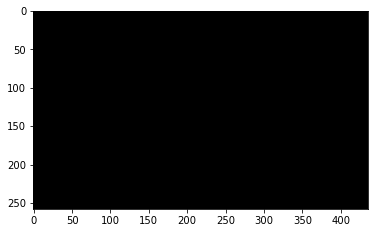

In [895]:
target_animal = 'band2'

## (1) Crop the bounding rect
rect = cv2.boundingRect(np.array(poly_int))
x,y,w,h = rect
croped = im[y-h:y+h, x-w:x+w].copy()

## (2) make mask
#pts = pts - np.array(pts).min(axis=0)
#pts_int = pts_int - np.array(pts_int).min(axis=0)
arr = np.array(pts_int)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [arr], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)
#%
rows, cols, _ = np.array(dst).shape
R, theta = get_2d_rotmat_multiindex(ix, df_ctr, target_animal, scorer=False, v=(0, 1))
print(np.rad2deg(theta))
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), np.rad2deg(theta),1)
dst2 = cv2.warpAffine(dst, M, (cols,rows))
#%
fig, ax = plt.subplots()
ax.imshow(dst2)

In [896]:
#contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#contours = contours[0] if len(contours) == 2 else contours[1]
# for cntr in contours:
#     x,y,w,h = cv2.boundingRect(cntr)
#     cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     print("x,y,w,h:",x,y,w,h)
# x,y,w,h = cv2.boundingRect(contours)
active_px = np.argwhere(mask!=0)
active_px = active_px[:,[1,0]]
x,y,w,h = cv2.boundingRect(active_px)    

In [897]:
(2/3.)*total_frames

5994.0

In [832]:
total_frames

8991.0

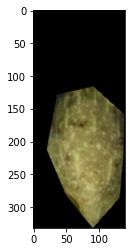

In [942]:
frames2 = []
# clip = vp(fname=video_fpath, fps=30)
# im = clip.load_frame()
# im = im[y1:y2, x1:x2]
fig, ax = plt.subplots()

cap = cv2.VideoCapture(video_fpath)
[x1, x2, y1, y2] = metadata["data"]["cropping_parameters"]

animalid = 'band2'

start=5000
stop=8000 #total_nframes

total_frames = cap.get(7)
for ix in np.arange(start, stop):
    cap.set(1, ix)
    ret, im = cap.read()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im[y1:y2, x1:x2]
    coords = xyp[ix, :, :]
    
    plot_ixs = [list(bodyparts).index(i) for i in np.unique(bodyparts2connect)]
    if animalid == 'band2':
        plot_ixs = np.array(plot_ixs) + n_bodyparts
    
    xv = coords[plot_ixs, 0]
    yv = coords[plot_ixs, 1]
    #polygon = np.array([[int(i[0]), int(i[1])] for i in coords[np.unique(inds)]])
    polygon = list(zip(xv, yv))
    try:
        polyshape = MultiPoint(polygon).convex_hull
    except Exception as e:
        continue
        
    # Extract the point values that define the perimeter of the polygon
    px, py = polyshape.exterior.coords.xy
    poly_ft = list(zip(px, py))
    poly = np.array(poly_ft) #.dot(R)

    int_px = [int(round(i)) for i in poly[:, 0]]
    int_py = [int(round(i)) for i in poly[:, 1]]
    #poly = list(zip(px, py))
    poly_int = list(zip(int_px, int_py)) ##DIAG

    # poly_ft = list(zip(px, py))
    # poly = list(zip(int_px, int_py))
    pts = np.array(poly_int.copy())
    #pts[:, 0] -= ctrs[ix, 0]
    #pts[:, 1] -= ctrs[ix, 1]
    pts_int = [[int(round(i[0])), int(round(i[1]))] for i in list(pts)]

    #%
    arr = np.array(pts_int)
    mask = np.zeros(im.shape[:2], np.uint8)
    cv2.drawContours(mask, [arr], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(im, im, mask=mask)
    #%
    rows, cols, _ = np.array(dst).shape
    R, theta = get_2d_rotmat_multiindex(ix, df_ctr, target_animal, scorer=False, v=(0, 1))
    # print(np.rad2deg(theta))
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), np.rad2deg(theta),1)
    dst2 = cv2.warpAffine(dst, M, (cols,rows))
    #%
    mask_rot = cv2.warpAffine(mask, M, (cols,rows))
    active_px = np.argwhere(mask_rot!=0)
    active_px = active_px[:,[1,0]]
    x,y,w,h = cv2.boundingRect(active_px)    
    #croped = dst2[y-h:y+h, x-w:x+w].copy()
    croped = dst2[y-h:y+h, x-w:x+w].copy()
    if not all(croped.shape):
        continue
    #%
    ax.imshow(croped[100:, 100:])
    ax.set_aspect('equal')
    #ax.imshow(croped[170:350, 120:])
    #ax.imshow(croped[170:350, 120:])
    frames2.append(croped)

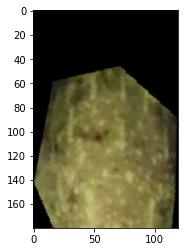

In [945]:
fig, ax = plt.subplots()
ax.imshow(croped[170:350, 120:])
ax.set_aspect('equal')         

In [946]:
croped.shape

(432, 240, 3)

In [947]:
outputframerate = 120
fps = outputframerate
codec="h264"

videooutname = os.path.join(video_dir, 'test-patterns_%i-%i_%s.mp4' % (start, stop, animalid))
output_name = videooutname

In [948]:
len(frames2)

2918

In [949]:
print(output_name)

n_frames = len(frames2)
figsize = (nx / dpi, ny / dpi)
prev_backend = plt.get_backend()
plt.switch_backend("agg")
fig = plt.figure(frameon=False, figsize=figsize)
ax = fig.add_subplot(111)

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
ax.axis("off")
# ax.add_patch(
#     plt.Rectangle(
#         (0, 0), 1, 1, facecolor=background_color, transform=ax.transAxes, zorder=-1
#     )
# )
im = ax.imshow(frames[0])
# ax.invert_yaxis()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

writer = FFMpegWriter(fps=fps, codec=codec)
with writer.saving(fig, output_name, dpi=dpi):
    writer.grab_frame()
    for index, _ in enumerate(trange(n_frames - 1), start=1):
        curr_im = frames2[index]
        im.set_array(curr_im[170:350, 120:])
        writer.grab_frame()
plt.close(fig)
plt.switch_backend(prev_backend)


/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/test-patterns_5000-8000_band2.mp4


100%|██████████████████████████████████████| 2917/2917 [01:36<00:00, 30.24it/s]


In [950]:
output_name

'/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/test-patterns_5000-8000_band2.mp4'

#### test frame

In [824]:

cap = cv2.VideoCapture(video_fpath)
total_frames = cap.get(7)
ix = 8000
[x1, x2, y1, y2] = metadata["data"]["cropping_parameters"]

cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = im[y1:y2, x1:x2]
coords = xyp[ix, :, :]

plot_ixs = [list(bodyparts).index(i) for i in np.unique(bodyparts2connect)]
xv = coords[plot_ixs, 0]
yv = coords[plot_ixs, 1]
#polygon = np.array([[int(i[0]), int(i[1])] for i in coords[np.unique(inds)]])
polygon = list(zip(xv, yv))
polyshape = MultiPoint(polygon).convex_hull


# Extract the point values that define the perimeter of the polygon
px, py = polyshape.exterior.coords.xy
poly_ft = list(zip(px, py))
poly = np.array(poly_ft) #.dot(R)

int_px = [int(round(i)) for i in poly[:, 0]]
int_py = [int(round(i)) for i in poly[:, 1]]
#poly = list(zip(px, py))
poly_int = list(zip(int_px, int_py)) ##DIAG

# poly_ft = list(zip(px, py))
# poly = list(zip(int_px, int_py))
pts = np.array(poly_int.copy())
#pts[:, 0] -= ctrs[ix, 0]
#pts[:, 1] -= ctrs[ix, 1]
pts_int = [[int(round(i[0])), int(round(i[1]))] for i in list(pts)]

2.5781988146654866


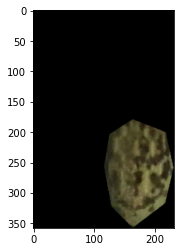

In [825]:
fig, ax = plt.subplots()

arr = np.array(pts_int)
mask = np.zeros(im.shape[:2], np.uint8)
cv2.drawContours(mask, [arr], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(im, im, mask=mask)
#%
rows, cols, _ = np.array(dst).shape
R, theta = get_2d_rotmat_multiindex(ix, df_ctr, target_animal, scorer=False, v=(0, 1))
print(np.rad2deg(theta))
M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), np.rad2deg(theta),1)
dst2 = cv2.warpAffine(dst, M, (cols,rows))
#%
mask_rot = cv2.warpAffine(mask, M, (cols,rows))
active_px = np.argwhere(mask_rot!=0)
active_px = active_px[:,[1,0]]
x,y,w,h = cv2.boundingRect(active_px)    
croped = dst2[y-h:y+h, x-w:x+w].copy()
ax.imshow(croped)

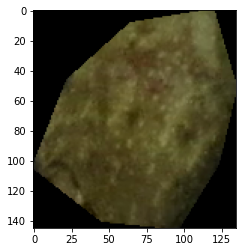

In [281]:
fig, ax = plt.subplots()
ax.imshow(dst)

In [303]:
ctrs.shape

(8991, 2)